<a href="https://colab.research.google.com/github/Yoel-G/Codes-for-Mechanomics-paper/blob/main/FCS_File_Analysis_FlowKit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**Author information:**

Ora T. Cohen, Lab of Prof. Ofra Benny

Hebrew University, School of Pharmacy

Contact: ora.cohen3@mail.huji.ac.il


####**Code description:**

*Source Code: RawData_pc3m-p and LN4 analysis-batch effect (Yoel Goldstein), convert_fcs_files_to_csv.ipynb (Ora Cohen)*

Script to convert .fcs files from FACS analysis to .csv files.


*   Requires file directory pointing to a folder containing raw .fcs files
*   Requires a file path to the spillover matrix in proper .csv format
*   Need to edit code parameters based on the data properties (magnitude for plottinx axes & index for the file number for the control)
*   Allows manual thresholding of .fcs data to filter out debris/doublets (as well as threshold visualization)
*   Includes code snippets to generate heatmap dotplots of FCS/SSC, histogram plots of intensity, and histogram plots of FCS/SSC
*   Outputs .csvs with each .fcs file data and compiled .csv with filtered data for all .fcs files (basically outputs a whole bunch of different .csvs)


####**Version information:**

(convert_fcs_files_to_csv.ipynb)

V1 (original edits to source code): 20/11/2022


*   Generalize code from a specific data set to any .fcs files
*   Auto-import list of files from a specified directory
*   Auto-generate plots for every file in the directory
*   Enable heatmap dot-plotting directly from .csv

V1.1 (minor edits): 21/11/2022

*  Fix data filtering/filtered data plotting
*  Remove <0 values prior to heatmap dot-plotting to allow log normalization
*  Add timestamp to .csv files to prevent overwriting (if thresholding parameters change)

(FCS_File_Analysis_FlowKit.ipynb)

V2 (change to using FlowKit): 15/12/2022

*  Load .fcs files using FlowKit library in order to do compensation
*  Change plotting to functions for easier customization between files
*  Add calculation of a bead uptake percentage matrix





# Section 1: Close your eyes & Run

This section installs the necessary libraries. Changes are only necessary if you decide to use something from a python library not already listed here.

In [ ]:
pylab inline

In [ ]:
pip install -U matplotlib==3.2

In [ ]:
pip install flowkit #Ora

In [ ]:
pip install datashader #Ora

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from pylab import *
import os #Ora
import fnmatch #Ora
import datashader as ds #Ora
from datashader.mpl_ext import dsshow #Ora
import time #Ora
import flowkit as fk #Ora

# Section 2: Customize (if you like) & Run

This section defines some functions to plot and visualize the data. If you like, you can change the formatting in these functions (colours, figure size, etc.) before running. If you want to get really fancy, you can add additional arguments (for things like colour, figure size, etc.) to be able to customize it for different plots, but just be sure to input these additional arguments when calling the function.

In [ ]:
#Function to produce dot plots with density (heatmap) colormap from .csv files

# Source code:
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762

# Additional documentation:
# https://datashader.org/getting_started/Interactivity.html

def using_datashader(ax, x, y, **kwargs):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=1,
        vmax=50,
        cmap='hot',
        norm="log",
        aspect="auto",
        ax=ax,
    )

In [ ]:
#function to produce heatmap-coded dot plots

'''
parameter descriptions:
* files - list of file names used to identify each sample
* total_data - dataframe containing all the samples to plot identified by file name
* x_axes - a list containing the column names of the data to plot on the x axis
           (the function will produce a plot for each x axis in the list)
* y_axes - a list containing the column names of the data to plot on the y axis
           (the function will produce a plot for each x axis in the list)
           (there must be an equal number of x axes and y axes)
* x_lims - right limit for the x axis on each plot (same length as x_axes)
* y_lims - top limit for the y axis on each plot (same length as y_axes)

WARNING - This function (which uses datashader to colourcode) does not seem to work well with intensity plots.
If you want to plot intensity as a dotplot, I'd recommend either using a regular scatter plot or using FlowCal (I know,
it sucks to have to import all your data both with FlowCal and FlowKit) or using FlowKit, but
then you need to use the sample class (not the dataframe) to produce the plot. I'll leave an example in the code)
'''

def plot_dotplot(files, total_data, x_axes, y_axes, x_lims, y_lims):

  for file in files:

    subset = total_data.loc[total_data['data_set'] == file] #get portion of total dataframe containing this sample

    fig, ax = plt.subplots(1,len(x_axes), figsize=(4*len(x_axes), 5))

    for ind in range(len(x_axes)):

      using_datashader(ax[ind], subset.loc[:, x_axes[ind]], subset.loc[:, y_axes[ind]])
      ax[ind].set_xlabel(x_axes[ind])
      ax[ind].set_ylabel(y_axes[ind])
      ax[ind].set_xlim(left=0, right= x_lims[ind])
      ax[ind].set_ylim(bottom=0, top=y_lims[ind])

    fig.tight_layout(pad=1.0)
    fig.suptitle(file.replace('.fcs', ''))
    fig.subplots_adjust(top=0.85)
    plt.show()
    print(' ')


In [ ]:
#function to produce histograms

'''
parameter descriptions:
* files - list of file names used to identify each sample
* control_ind - the index for the file name of the control in the files list
* total_data - dataframe containing all the samples to plot identified by file name
* n_bins - number of bins to use for the histogram
* threshold - value at which to filter the data (plots only data > threshold)
* x_axes - a list containing the column names of the data to plot on the x axis
           (the function will produce a plot for each x axis in the list)
* plot_control - plot sample as well as control on each plot (1 -> control+sample, 0 -> sample only)
'''

def plot_histogram(files, control_ind, total_data, n_bins, thresholds, x_axes, plot_control):

  control = total_data.loc[total_data['data_set'] == files[control_ind]]

  for file in files:

    subset = total_data.loc[total_data['data_set'] == file] #get portion of total dataframe containing this sample

    fig, ax = plt.subplots(1,len(x_axes), figsize=(6*len(x_axes), 5))

    for ind in range(len(x_axes)):
      pos_subset = subset[subset[x_axes[ind]]>thresholds[ind]]

      ax[ind].hist(pos_subset[x_axes[ind]], bins=n_bins, alpha=0.5, label="sample", color = 'lightblue', edgecolor = "lightblue", weights=np.ones_like(pos_subset[x_axes[ind]]) / len(subset[x_axes[ind]]))

      if plot_control:
        pos_control = control[control[x_axes[ind]]>thresholds[ind]]
        ax[ind].hist(pos_control[x_axes[ind]], bins=n_bins, alpha=0.3, label="control", color = 'pink', edgecolor = "pink", weights=np.ones_like(pos_control[x_axes[ind]]) / len(control[x_axes[ind]]))

      ax[ind].set_xlabel(x_axes[ind], size=14)
      ax[ind].set_ylabel("Percent", size=14)
      ax[ind].set_xlim(left=np.maximum(1e0, thresholds[ind]), right = 1e7)
      ax[ind].set_xscale('log')
      ax[ind].set_title(file.replace('.fcs', '')+" Uptake")
      ax[ind].legend(loc='upper right')
      ax[ind].yaxis.set_major_formatter(PercentFormatter(1))
      ax[ind].grid(False)

    plt.show()
    print(' ')


#Section 3: Check & Run

This section is where you'll want to start running cells one at a time and making sure things are happening the way you want them to. There's still not a lot of things you have to customize, but here and there you'll want to edit a file path or check that your data is still looking like its supposed to. There's an "#EDIT THIS" comment line where you should edit things to match your data/files.

In [ ]:
#Mount Google drive
from google.colab import drive

drive.mount('/content/drive')

#EDIT THIS - should point to a folder containing raw .fcs files
data_path = r'' # enter your path

cell_type = '' #EDIT THIS - is used in filename at some point, along with the date and data_path

In [ ]:
Total_data = pd.DataFrame() #empty dataframe to merge all sample dataframes
all_data_ever = pd.DataFrame() #empty dataframe to merge all all dataframes, including compensation controls

fcs_files_list = os.listdir(data_path) #Read all files in a specified directory (data_path)

#EDIT THIS - the string which comes after "file_name" should be a unique and common string in the file name of all the files you want to analyse (must be .fcs)
bad_files = [fnmatch.fnmatch(file_name, '*fcs') for file_name in fcs_files_list] #to remove any files in the folder which are not .fcs from the file list
remove_files = [ind for ind, x in enumerate(bad_files) if not x] #get indices of unwanted files
remove_files.sort(reverse=True) #sort indices in reverse order

for i in remove_files:
  fcs_files_list.remove(fcs_files_list[i]) #delete files which are not .fcs from the files_list

fcs_files_samples = fcs_files_list.copy() #copy the file list containing only .fcs files

#EDIT THIS - the string which comes after "file_name" should be a unique and common string in the file name of all compensation controls you may want to exclude from analysis
bad_files = [fnmatch.fnmatch(file_name, 'Compensation Control*') for file_name in fcs_files_list] #to remove any .fcs files which are compensation controls from the file list
remove_files = [ind for ind, x in enumerate(bad_files) if x] #get indices of unwanted files
remove_files.sort(reverse=True) #sort indices in reverse order

for i in remove_files:
  fcs_files_samples.remove(fcs_files_samples[i]) #delete files which are compensation controls from the files_list

In [ ]:
#Here we save all the data into .csv files

Total_data = pd.DataFrame() #empty dataframe to merge all sample dataframes
for file_name in fcs_files_samples: #for every .fcs file in the folder besides compensation controls
  datafile = data_path + file_name #set file path
  sample = fk.Sample(datafile, cache_original_events=True) #read file into a dataframe
  df = sample.as_dataframe(source='raw')
  df = df.droplevel('pns', axis=1)
  df['data_set'] = file_name #add a column to keep track of which file the data is from
  Total_data = pd.concat([Total_data, df], ignore_index=True) #append to master dataframe
  df.to_csv(data_path+file_name.replace('.fcs', '.csv')) #overwrite existing csv file to save with data_set label

In [ ]:
#Here we change column names to remove characters that make python cranky (change based on columns in your .csv files!)

Total_data = Total_data.rename(columns={"FSC-A": "FSC_A", "FSC-H": "FSC_H", "FSC-W": "FSC_W", "SSC-A": "SSC_A", "SSC-H": "SSC_H", 'SSC-W': 'SSC_W',
                                        'FITC-A': 'Yellow_1.33_A', 'dTomato-A': 'Pink_0.81_A', 'Alexa Fluor 700-A': 'SkyBlue_2.07_A'}) #pnn names

In [ ]:
#Time to filter out negative or zero physiological values, because otherwise we can't logscale our plot
Total_nonzero_data = Total_data
Total_nonzero_data = Total_nonzero_data[Total_nonzero_data['SSC_A'] > 0.01]
Total_nonzero_data = Total_nonzero_data[Total_nonzero_data['FSC_A'] > 0.01]
Total_nonzero_data = Total_nonzero_data[Total_nonzero_data['FSC_H'] > 0.01]
Total_nonzero_data = Total_nonzero_data[Total_nonzero_data['SSC_H'] > 0.01]
Total_nonzero_data = Total_nonzero_data[Total_nonzero_data['FSC_W'] > 0.01]
Total_nonzero_data = Total_nonzero_data[Total_nonzero_data['SSC_W'] > 0.01]

#Section 4: Go Slow and Make it yours

Here we get to the fun part 🙃 (did you know that colab had emojis??)! Here you get to choose what you want to plot and how you want to threshold your data etc etc. Since everything is plotted in a loop, you can start by passing the functions just one file (or actually maybe two, if you give it one the loop might crash) to set the parameters properly before running it on all the files.

###Physiological analysis - finding and filtering for the cell population

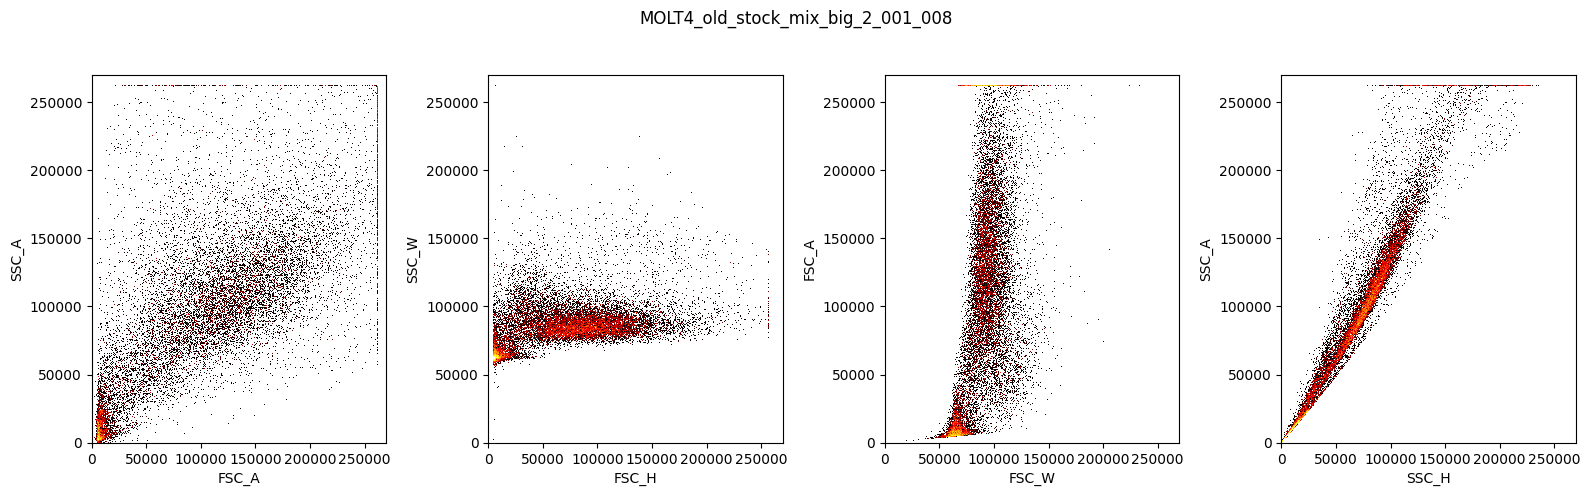

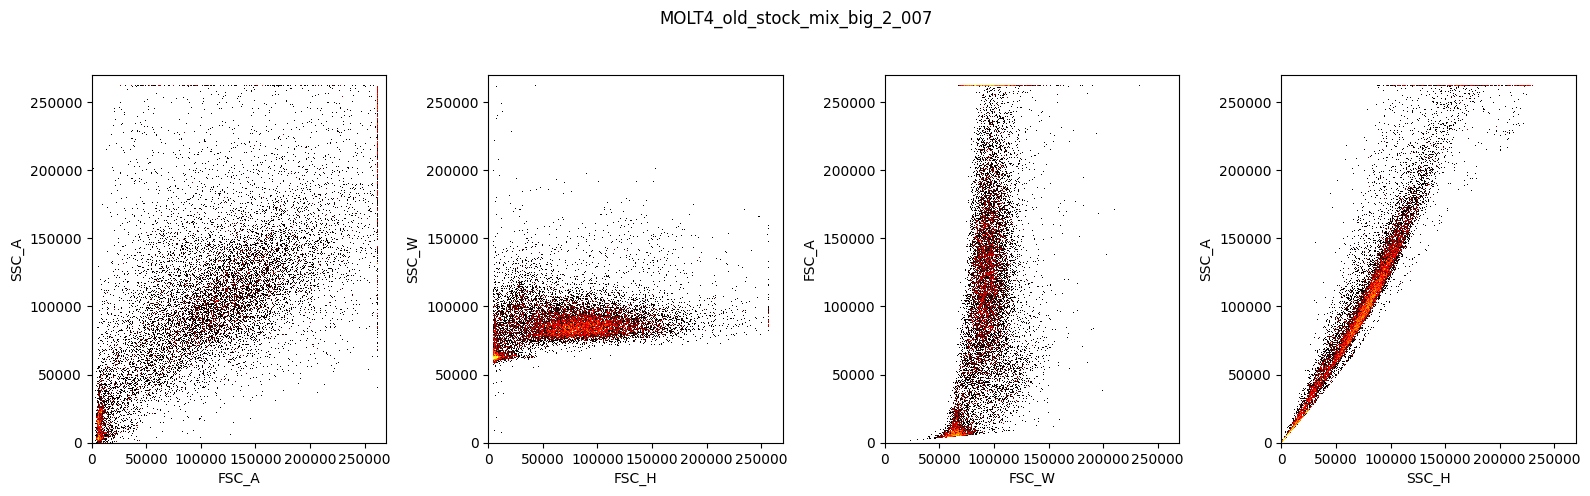

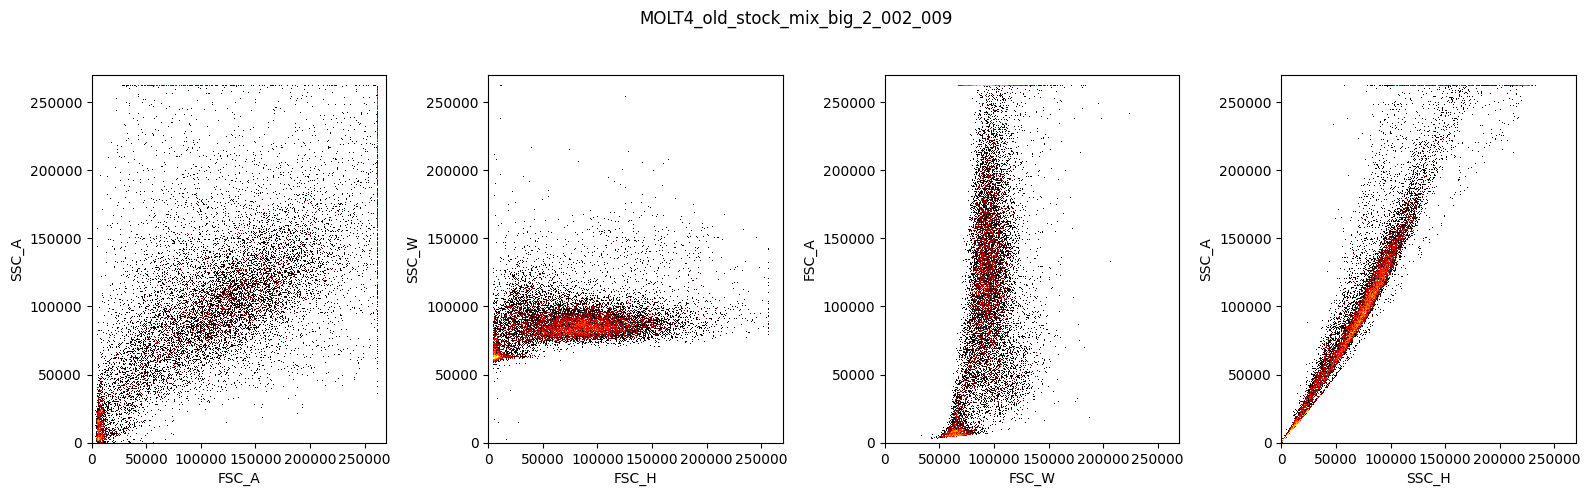

In [ ]:
#Here you can produce some nice dotplot heatmaps to check how your data looks.
#I chose to make four graphs, you can make more or less and change the axes as you please

#These are the axis limits for different physiological paramters - it varies with the data
SSC_H_lim = 2.7e5 #EDIT THIS
SSC_A_lim = 2.7e5 #EDIT THIS
FSC_H_lim = 2.7e5 #EDIT THIS
FSC_A_lim = 2.7e5 #EDIT THIS
FSC_W_lim = 2.7e5 #EDIT THIS
SSC_W_lim = 2.7e5 #EDIT THIS

x_axes = ['FSC_A', 'FSC_H', 'FSC_W', 'SSC_H'] #EDIT THIS
y_axes = ['SSC_A', 'SSC_W', 'FSC_A', 'SSC_A'] #EDIT THIS

x_lims = [FSC_A_lim, FSC_A_lim, FSC_A_lim, SSC_A_lim] #EDIT THIS
y_lims = [SSC_A_lim, SSC_H_lim, FSC_H_lim, SSC_H_lim] #EDIT THIS

#EDIT THIS - this is plotting basically all the data to see where the cell population is
plot_dotplot(fcs_files_samples, Total_nonzero_data, x_axes, y_axes, x_lims, y_lims)

In [ ]:
#Thresholding

#Based on the plots above, you can set the thresholds to filter for your cell population (use as many parameters as you see fit)

#Edit the threshold values to filter your data as you like
Total_filtered_data = Total_nonzero_data
Total_filtered_data = Total_filtered_data[Total_filtered_data['SSC_A'] > 2.5e4] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['SSC_A'] < 17e4] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['SSC_W'] > 6.5e4] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['SSC_W'] < 1.2e5] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['FSC_H'] < 1.5e5] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['SSC_A'] < 2e5] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['FSC_A'] > 5e4] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['FSC_A'] < 2.25e5] #EDIT THIS
Total_filtered_data = Total_filtered_data[Total_filtered_data['FSC_W'] > 7.5e4] #EDIT THIS

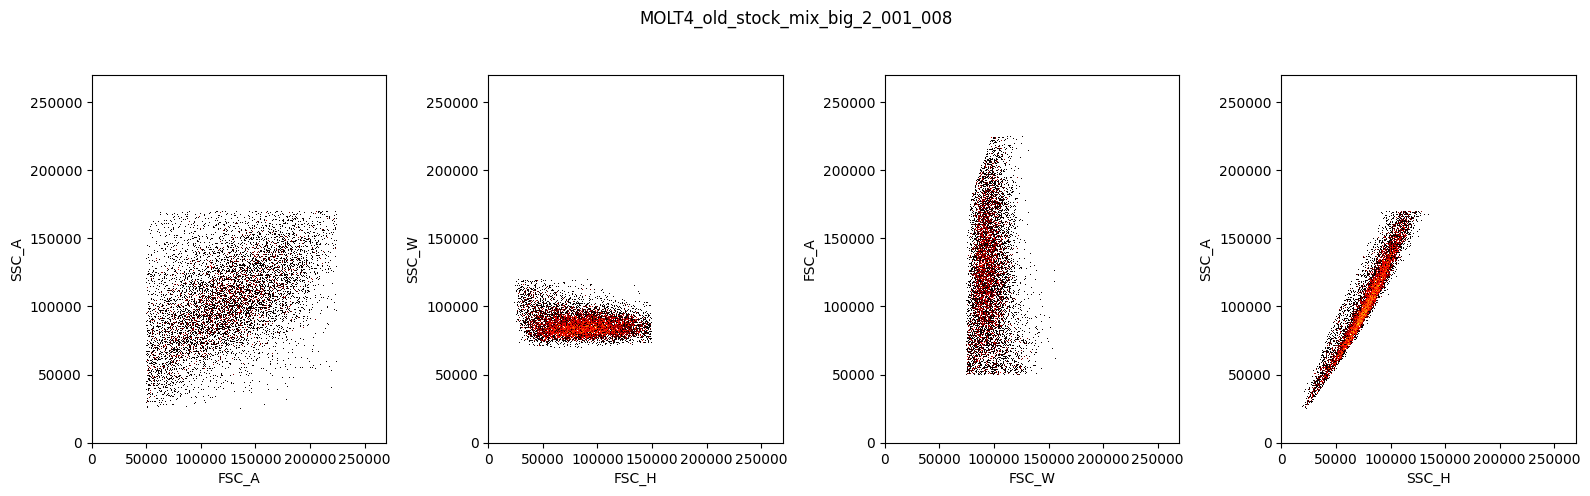

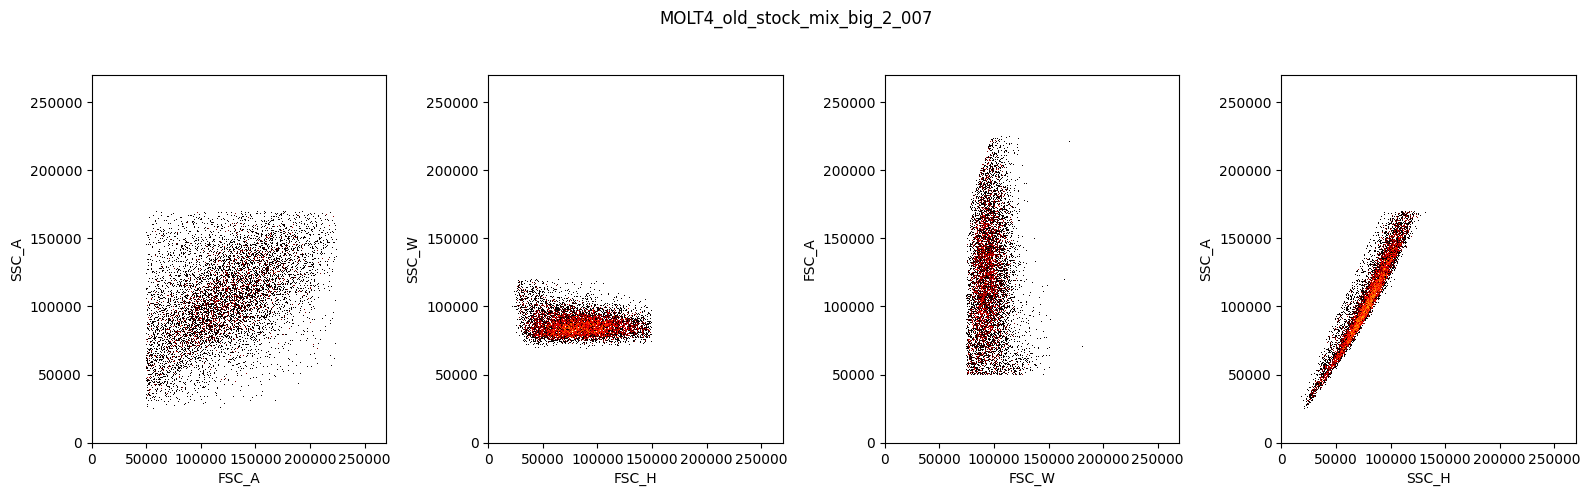

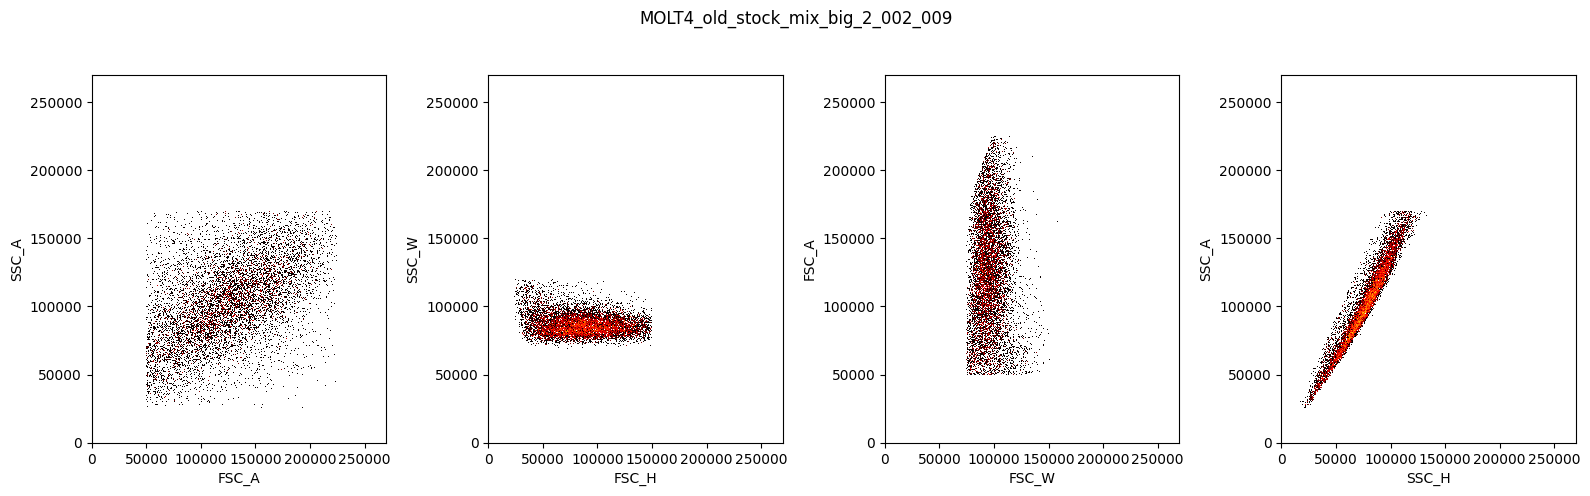

In [ ]:
#Now we're plotting the filtered version! You can enter different axes or limits or file set
x_axes = ['FSC_A', 'FSC_H', 'FSC_W', 'SSC_H'] #EDIT THIS
y_axes = ['SSC_A', 'SSC_W', 'FSC_A', 'SSC_A'] #EDIT THIS

x_lims = [FSC_A_lim, SSC_H_lim, FSC_A_lim, SSC_A_lim] #EDIT THIS
y_lims = [SSC_A_lim, FSC_W_lim, FSC_H_lim, SSC_H_lim] #EDIT THIS

plot_dotplot(fcs_files_samples, Total_filtered_data, x_axes, y_axes, x_lims, y_lims)

#If you don't like the filtering, you can choose new threshold values and filter and plot again, over and over, until you're happy
#You can also check the physiological histograms (below)